In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [385]:
import numpy as np
import pandana as pdna
import geopandas as gpd
import pandas as pd
import osmnx as ox
import math
import networkx as nx
import sys
import matplotlib.pyplot as plt
# adding functions 
sys.path.insert(0, 'C:\\Users\\z3258367\\OneDrive - UNSW\\#PhD\\Walkability\\Other Cities\\Open-Walk-Index')
from walkability_functions import *
from graph_utils import *

In [180]:
import matplotlib_scalebar 
from matplotlib_scalebar.scalebar import ScaleBar

Choose a projected CRS to be used for all distance calculations.

In [10]:
folder = "C:\\Users\\z3258367\\OneDrive - UNSW\\#PhD\\Walkability\\Other Cities\\Colouring data & results\\"
proj_crs = "EPSG:7856"

#place = 'Canberra, Australia'
#place_gdf = ox.geocode_to_gdf(place).to_crs(proj_crs)

place_gdf = gpd.read_file(folder + 'Canberra Data\\Canberra Metro SA3s.gpkg', crs="EPSG:4326").to_crs(proj_crs)

## Import Data

Data sources:
1. OSM POIs
5. Employment data - find govt source

In [11]:
poi_dictionary = {
    'employment':{
        'category':['employment']
    },
    'shopping':{
        'shop':['bakery', 'clothes', 'supermarket', 'mall', 'greengrocer',
                'seafood', 'wine', 'butcher','convenience',
                'beverages', 'alcohol', 'bicycle_shop', 'department_store', 
                'doityourself', 'beauty_shop', 'outdoor_shop', 
                'stationery', 'bookshop', 'gift_shop', 'newsagent', 
                'car_dealership', 'furniture_shop', 'sports_shop',
                'garden_centre', 'computer_shop', 'shoe_shop', 'florist', 
                'video_shop', 'toy_shop', 'mobile_phone_shop', 'jeweller'],
        # possibly we could pick up all shop=True excluding a few. but not sure how
        # and many options to exclude
        'amenity':['marketplace'],
        'building':['kiosk', 'supermarket',],
    },
    'errands':{
        'amenity':['atm','bank','courthouse','post_box', 'post_office',
                   'clinic', 'dentist', 'doctors', 'hospital',
                   'pharmacy', 'veterinary', 'travel_agent',
                   'place_of_worship'],
        'shop':['optician', 'hairdresser', 'laundry',],
        'healthcare':['physiotherapist'],
        'office':['government'], #### further refine ?
    },
    'recreation':{
        'leisure':['dog_park', 'ice_rink', 'park', 'pitch', 'playground',
                   "fitness_centre","sports_centre", 'stadium', 'swimming_pool',
                   'swimming_area', 'track', 'water_park','golf_course',],
        'club':['social'],
        'amenity':['bar', 'biergarten', 'cafe', 'fast_food', 'food_court',
                   'ice_cream', 'pub', 'restaurant', 'nightclub',
                   'library', 'arts_centre', 'cinema', 'community_centre',
                   'social_centre', 'theatre',],
        'building':['stadium', 'castle', 'ruins',],
        'tourism':['aquarium', 'artwork', 'attraction', 'gallery',
                   'museum', 'picnic_site', 'theme_park', 'viewpoint',
                   'zoo'],
        'natural':['beach'],
    },
    'education':{
        'amenity':['college', 'kindergarten', 'music_school',
                   'school', 'university', 'childcare'],
    }
}

In [12]:
osm_pois = poi_downloader(place_gdf, poi_dictionary, proj_crs)

C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\osmnx\geometries.py:805: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):
C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\osmnx\geometries.py:805: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):


In [13]:
employment_centrs = gpd.read_file((folder + 
                        "Canberra Data\\ACT_Employment_meshblocks.gpkg"), layer='centroids').to_crs(proj_crs)

employment_centrs['category'] = 'employment'
employment_centrs['geometry'] = employment_centrs.geometry.centroid

Need to remove potential overlap between different data sources (and inside some data sources). For now I'm not worrying about this when using only OSM data. Then take this combined POI set and clip it to the study area: should be the same area as is covered by the network. This is important otherwise points outside the network may be erroneously linked to the network.

In [14]:
pois = pd.concat([osm_pois, employment_centrs])

pois = gpd.clip(pois, place_gdf.to_crs(proj_crs))

### Categorise and weight POIs

Choose walk index weightings, and output the sums of each category and the total to check. The walk index will be out of 100 regardless of this sum, but it is important to note that eg. shopping is only '10% of the walk index' if shopping is 10 out of 100.

In [15]:
poi_parameters = pd.read_csv((folder + 
                              "Shared Aus Data\\poi_parameters_5.csv"),
                            index_col=0)

In [16]:
poi_weights = poi_parameters['weight']

poi_lambdas = poi_parameters['diminishing_returns_constant']

poi_variables = poi_parameters['variable']

poi_nums = poi_parameters['num_pois']

poi_gammas = poi_parameters['distance_constant']

In [17]:
total = sum(poi_weights)
print("total: ", total)

total:  100.00000000000001


In [18]:
poi_variables.loc['employment'] = 'Jobs'
poi_nums.loc['employment'] = 600

<ipython-input-18-f6db0b834d9f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poi_variables.loc['employment'] = 'Jobs'
<ipython-input-18-f6db0b834d9f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poi_nums.loc['employment'] = 600


### Import network

Pandana expects edges to have a two item index based on the same IDs as the node index. (with thanks to https://github.com/shriv/accessibility-series/blob/master/Accounting%20for%20hills%20in%20accessibility%20analyses.ipynb)

In [19]:
#G = ox.graph_from_place(place, network_type='walk')
G = ox.graph.graph_from_polygon(place_gdf.to_crs('EPSG:4326').geometry[0], network_type='walk')

In [20]:
# Get nodes and edges as geodataframes (gdfs) from OSMNX network
graph_df = ox.graph_to_gdfs(G)
nodes_gdfs = graph_df[0]
edges_gdfs = graph_df[1]

In [21]:
edges_gdfs = edges_gdfs.to_crs(proj_crs)
nodes_gdfs = nodes_gdfs.to_crs(proj_crs)

## Pandana network creation.

In [22]:
# with new OSMnx graph from polygon seems to be different
edges_gdfs = edges_gdfs.reset_index()
# Setting indices of Edges gdfs to match expected dataframe for Pandana
edges_gdfs['from_idx'] = edges_gdfs['u']
edges_gdfs['to_idx'] = edges_gdfs['v']
edges_gdfs= edges_gdfs.set_index(['from_idx', 'to_idx'])
edges_gdfs.index.names= ['','']

# Setting indices of Nodes gdfs to match expected dataframe for Pandana
nodes_gdfs.index.name = 'id'
# Create a pandana network with data extracted from an OSMNX graph
distance_network = pdna.Network(nodes_gdfs.geometry.x, nodes_gdfs.geometry.y,
                                   edges_gdfs['u'], edges_gdfs['v'], 
                                   edges_gdfs[['length']])

### Pandana network querying. 

In [23]:
maximum_dist=2400

In [383]:
results_walk = there_index(distance_network, pois, poi_dictionary, poi_weights, poi_gammas,
                            poi_nums, poi_lambdas, poi_variables, distance=maximum_dist)

Finished category: employment
Maximum score: 9.277390535246456 out of 31.9
Finished category: education
Maximum score: 11.211631484540554 out of 14.3
Finished category: shopping
Maximum score: 21.26220847259792 out of 21.6
Finished category: errands
Maximum score: 8.783850937392 out of 8.9
Finished category: recreation
Maximum score: 23.265818713739947 out of 23.3


In [386]:
results_walk = there_index(distance_network, pois, poi_dictionary, poi_weights, poi_gammas,
                            poi_nums, poi_lambdas, poi_variables, distance=maximum_dist)

Finished category: employment
Maximum score: 9.277390535246456 out of 31.9
Finished category: education
Maximum score: 11.211631484540554 out of 14.3
Finished category: shopping
Maximum score: 21.26220847259792 out of 21.6
Finished category: errands
Maximum score: 8.783850937392 out of 8.9
Finished category: recreation
Maximum score: 23.265818713739947 out of 23.3


In [387]:
max(results_walk['THERE_Index']), np.mean(results_walk['THERE_Index'])

(66.50119969626057, 29.255990124601546)

In [374]:
#old results 66.5 29.3

(66.50119969626057, 29.255990124601546)

In [388]:
small_w_results = gpd.GeoDataFrame(result_rounding(results_walk), geometry = gpd.GeoSeries.from_xy(results_walk.x, results_walk.y, crs=proj_crs))

In [389]:
small_w_results.to_file((folder +
                         "Canberra Data\\" + 
                         "Canberra_walk_211022.gpkg"))

C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\geopandas\io\file.py:389: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(gdal_version) >= LooseVersion("3.0.0") and crs:


C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\geopandas\plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


<AxesSubplot:>

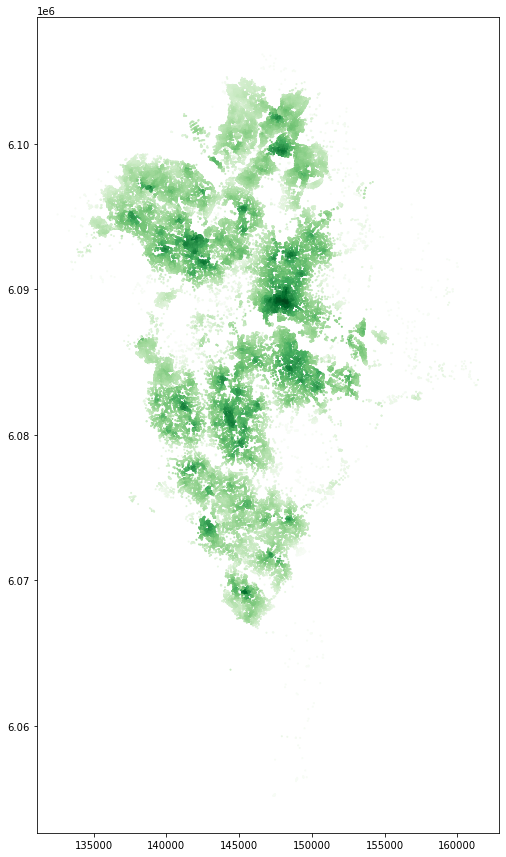

In [390]:
small_w_results.plot('THERE_Index', figsize=(12,15), cmap='Greens',markersize=1)

The current approach is to find up to x closest nodes for each category within the maximum distance. Then look up the attractiveness at each one (just count for most), apply a distance decay function to each distance, apply diminishing returns to the resulting total opportunity, and sum.

An alternative approach which would be more convenient would be to use the Pandana 'aggregate' function which aggregates from all nodes within the maximum distance including applying a decay function. However, there is limited ability to change the distance decay rate within the aggregation function. It can either be flat (no decay), linear (going to 0 at the max distance), or exponential where beta is set as 1/max distance. For walking I would like a beta of 0.001, but this requires the radius to be 1000m. If the radius is 2400m, beta is only 0.0004. This can be changed in the future if the Pandana function is updated to take a decay parameter.

## Cycling

In [ ]:
#C = ox.graph_from_place(place, network_type='bike')
C = ox.graph.graph_from_polygon(place_gdf.to_crs("EPSG:4326").geometry[0], network_type='bike')

In [ ]:
# Get nodes and edges as geodataframes (gdfs) from OSMNX network
graph_df = ox.graph_to_gdfs(C)
nodes_gdfs = graph_df[0]
edges_gdfs = graph_df[1]

In [ ]:
edges_gdfs = edges_gdfs.to_crs(proj_crs)
nodes_gdfs = nodes_gdfs.to_crs(proj_crs)

In [ ]:
# with new OSMnx graph from polygon seems to be different
edges_gdfs = edges_gdfs.reset_index()
# Setting indices of Edges gdfs to match expected dataframe for Pandana
edges_gdfs['from_idx'] = edges_gdfs['u']
edges_gdfs['to_idx'] = edges_gdfs['v']
edges_gdfs= edges_gdfs.set_index(['from_idx', 'to_idx'])
edges_gdfs.index.names= ['','']

# Setting indices of Nodes gdfs to match expected dataframe for Pandana
nodes_gdfs.index.name = 'id'
# Create a pandana network with data extracted from an OSMNX graph
cycle_network = pdna.Network(nodes_gdfs.geometry.x, nodes_gdfs.geometry.y,
                                   edges_gdfs['u'], edges_gdfs['v'], 
                                   edges_gdfs[['length']])

In [ ]:
cycle_gammas = poi_gammas.copy()
cycle_gammas = cycle_gammas.replace(to_replace=0.001, value=0.0002)
cycle_gammas

### Pandana network querying. 

In [ ]:
cycle_dist = 12000

In [ ]:
cycle_results = there_index(cycle_network, pois, poi_dictionary, poi_weights, cycle_gammas,
                            poi_nums, poi_lambdas, poi_variables, distance=cycle_dist)

In [ ]:
#max(results['THERE_Index']), 
max(cycle_results['THERE_Index'])

In [ ]:
#np.mean(results['THERE_Index']), 
np.mean(cycle_results['THERE_Index'])

### Driving

In [ ]:
#C = ox.graph_from_place(place, network_type='bike')
D = ox.graph.graph_from_polygon(place_gdf.to_crs("EPSG:4326").geometry[0], network_type='drive')

In [ ]:
# Get nodes and edges as geodataframes (gdfs) from OSMNX network
graph_df = ox.graph_to_gdfs(D)
nodes_gdfs = graph_df[0]
edges_gdfs = graph_df[1]

In [ ]:
# must convert to the same CRS that POIs are in, or vice versa
edges_gdfs = edges_gdfs.to_crs(proj_crs)
nodes_gdfs = nodes_gdfs.to_crs(proj_crs)

In [ ]:
# with new OSMnx graph from polygon seems to be different
edges_gdfs = edges_gdfs.reset_index()
# Setting indices of Edges gdfs to match expected dataframe for Pandana
edges_gdfs['from_idx'] = edges_gdfs['u']
edges_gdfs['to_idx'] = edges_gdfs['v']
edges_gdfs= edges_gdfs.set_index(['from_idx', 'to_idx'])
edges_gdfs.index.names= ['','']

# Setting indices of Nodes gdfs to match expected dataframe for Pandana
nodes_gdfs.index.name = 'id'
# Create a pandana network with data extracted from an OSMNX graph
drive_network = pdna.Network(nodes_gdfs.geometry.x, nodes_gdfs.geometry.y,
                                   edges_gdfs['u'], edges_gdfs['v'], 
                                   edges_gdfs[['length']])

In [ ]:
drive_gammas = poi_gammas.copy()
drive_gammas = drive_gammas.replace(to_replace=0.001, value=0.00005)
drive_gammas

### Pandana network querying. 

In [ ]:
drive_dist = 24000

In [ ]:
drive_results = there_index(drive_network, pois, poi_dictionary, poi_weights, drive_gammas,
                            poi_nums, poi_lambdas, poi_variables, distance=drive_dist)

In [ ]:
#max(results['THERE_Index']), max(cycle_results['THERE_Index']), 
max(drive_results['THERE_Index'])

In [ ]:
#np.mean(results['THERE_Index']), np.mean(cycle_results['THERE_Index']), 
np.mean(drive_results['THERE_Index'])

In [ ]:
#new
np.mean(drive_results['THERE_Index'])

In [ ]:
small_d_results = gpd.GeoDataFrame(result_rounding(drive_results), geometry = gpd.GeoSeries.from_xy(drive_results.x, drive_results.y, crs=proj_crs))

In [ ]:
sum(meshblocks_j['Person'])/sum(employment_centrs['Jobs'])

In [ ]:
sum(employment_centrs['Jobs'])

## Export results

Reduce the number of decimal places before export, distances do not need to be below 1m.

In [27]:
def result_rounding(results):
    # reduces results size for export
    # score columns such as Walk_Index, employment_23 -> 3 decimal places
    # distance columns such as employment1 -> 0 decimal places (nearest metre)
    # avoid doing anything to connect_id, x or y
    rounding_dict = {**{k:3 for k in results.columns if "Index" in k or "." in k
                        and 'connect_id' not in k},
                     **{k:0 for k in results.columns if "Index" not in k and "." not in k
                        and k != 'x'
                        and k != 'y'}}
    return results.round(rounding_dict)

In [ ]:
small_c_results = gpd.GeoDataFrame(result_rounding(cycle_results), geometry = gpd.GeoSeries.from_xy(cycle_results.x, cycle_results.y, crs=proj_crs))

In [ ]:
small_results.to_file((folder +
                         "Canberra Data\\" + 
                         "Canberra_walk_090622.gpkg"))
small_c_results.to_file((folder + "Canberra Data\\" + 
                         "Canberra_cycle_090622.gpkg"))

 ### Population weighted results

In [76]:
meshblocks = gpd.read_file(folder + "Canberra Data\\2016_ACT_MBs\\MB_2016_ACT.shp").to_crs(proj_crs)

In [77]:
pop = pd.read_csv(folder + "Shared Aus Data\\2016 census mesh block counts.csv")

In [78]:
pop = pop.set_index('MB_CODE_2016')

In [79]:
meshblocks['MB_CODE16'] = meshblocks['MB_CODE16'].astype('int64')

In [80]:
meshblocks = meshblocks.join(pop, on='MB_CODE16', how='left')

In [81]:
meshblocks['orig_geometry'] = meshblocks.geometry
meshblocks.geometry = meshblocks.centroid

In [82]:
meshblocks_j = meshblocks_j.join(meshblocks.set_index('MB_CODE16'),on='MB_CODE16',how='left',rsuffix='right')

NameError: name 'meshblocks_j' is not defined

In [83]:
meshblocks_j = meshblocks.sjoin_nearest(small_results, how='left', rsuffix = 'walk')

NameError: name 'small_results' is not defined

In [ ]:
meshblocks_j = meshblocks_j.drop('orig_geometry',axis=1)

In [ ]:
meshblocks_j = meshblocks_j.clip(place_gdf)

In [ ]:
meshblocks_j = gpd.read_file(folder + "Canberra Data\\Canberra MB results 110622.gpkg")

In [ ]:
meshblocks_j = meshblocks_j.drop(meshblocks_j.columns[58:93],axis=1)

In [ ]:
meshblocks_c = meshblocks_j.sjoin_nearest(small_c_results, how='left', rsuffix = 'c')

In [ ]:
meshblocks_d = meshblocks_c.sjoin_nearest(small_d_results, how='left', lsuffix = 'cycle' , rsuffix = 'drive')

In [ ]:
meshblocks_pt = meshblocks_d.sjoin_nearest(small_pt_results.to_crs(proj_crs), how='left', rsuffix = 'transit')

In [394]:
meshblocks_w = meshblocks_pt.sjoin_nearest(small_w_results.to_crs(proj_crs), how='left', rsuffix = 'walking')

In [395]:
sum(meshblocks_w['Persons']*meshblocks_w['THERE_Index_walking'])/sum(meshblocks_w['Persons'])

28.476355664622528

In [ ]:
sum(meshblocks_d['Persons']*meshblocks_d['THERE_Index_cycle'])/sum(meshblocks_d['Persons'])

In [ ]:
sum(meshblocks_d['Persons']*meshblocks_d['THERE_Index_drive'])/sum(meshblocks_d['Persons'])

In [392]:
sum(meshblocks_pt['Persons']*meshblocks_pt['THERE_Index'])/sum(meshblocks_pt['Persons'])

51.16970387923544

In [329]:
meshblocks_pt = meshblocks_pt[~meshblocks_pt['THERE_Index'].isna()]

In [ ]:
meshblocks_w.to_file((folder + "Canberra Data\\Canberra MB results 4m 160622.gpkg"))

In [ ]:
results = gpd.read_file(folder + "Canberra Data\\Canberra MB results 4m 160622.gpkg")

In [ ]:
cm = plt.cm.Greens
bins=[10,20,30,40,50,60,70,80,90,100]
fig, ax1 = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(12, 4))
fig.set_figwidth(4)
ax1.set_xlabel('WalkTHERE')
ax1.set_ylabel('Residents')
fig.suptitle('Canberra: distribution of results by residential population')

n, bins, patches = plt.hist(results['THERE_Index_w'], weights = results['Person'], label='WalkTHERE',bins=bins)
for i, p in enumerate(patches):
    plt.setp(p, 'facecolor', cm(i/10 + 0.2)) # notice the i/25
    
plt.show()

### Public transport

In [29]:
import urbanaccess as ua
from urbanaccess.config import settings
from urbanaccess.gtfsfeeds import feeds
from urbanaccess import gtfsfeeds
from urbanaccess.gtfs.gtfsfeeds_dataframe import gtfsfeeds_dfs
from urbanaccess.network import ua_network, load_network

In [30]:
bbox = place_gdf.to_crs("EPSG:4326").bounds
bbox_points = (bbox['minx'][0], bbox['miny'][0], bbox['maxx'][0], bbox['maxy'][0])

loaded_feeds = ua.gtfs.load.gtfsfeed_to_df(gtfsfeed_path=(folder + "Canberra Data\GTFS"), 
                                     validation=True, 
                                     verbose=True, 
                                     bbox=bbox_points, 
                                     remove_stops_outsidebbox=True, 
                                     append_definitions=True)

<>:4: DeprecationWarning: invalid escape sequence \G
<>:4: DeprecationWarning: invalid escape sequence \G
<ipython-input-30-ceddcc9a7301>:4: DeprecationWarning: invalid escape sequence \G
  loaded_feeds = ua.gtfs.load.gtfsfeed_to_df(gtfsfeed_path=(folder + "Canberra Data\GTFS"),


Checking GTFS text file header whitespace... Reading files using encoding: utf-8 set in configuration.
GTFS text file header whitespace check completed. Took 1.08 seconds
--------------------------------
Processing GTFS feed: GTFS
The unique agency id: transport_canberra was generated using the name of the agency in the agency.txt file.
Unique agency id operation complete. Took 0.03 seconds
Unique GTFS feed id operation complete. Took 0.00 seconds
No GTFS feed stops were found to be outside the bounding box coordinates
GTFS GTFS feed stops: coordinates are in southeast hemisphere. Latitude = South (-90); Longitude = East (90).
Appended route type to stops
Appended route type to stop_times
--------------------------------
Added descriptive definitions to stops, routes, stop_times, and trips tables
Successfully converted ['departure_time'] to seconds past midnight and appended new columns to stop_times. Took 2.62 seconds
1 GTFS feed file(s) successfully read as dataframes:
     GTFS
    

<AxesSubplot:xlabel='stop_lon', ylabel='stop_lat'>

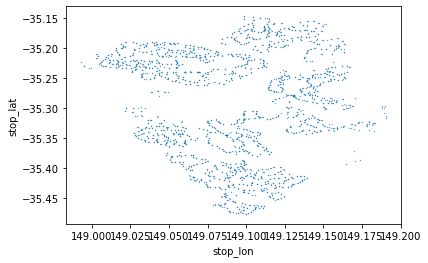

In [31]:
loaded_feeds.stops.plot(kind='scatter', x='stop_lon', y='stop_lat', s=0.1)

In [32]:
ua.gtfs.network.create_transit_net(gtfsfeeds_dfs=loaded_feeds,
                                   day='monday',
                                   timerange=['07:00:00', '10:00:00'],
                                   calendar_dates_lookup=None)

Using calendar to extract service_ids to select trips.
3 service_ids were extracted from calendar
12,818 trip(s) 68.77 percent of 18,640 total trip records were found in calendar for GTFS feed(s): ['gtfs']
NOTE: If you expected more trips to have been extracted and your GTFS feed(s) have a calendar_dates file, consider utilizing the calendar_dates_lookup parameter in order to add additional trips based on information inside of calendar_dates. This should only be done if you know the corresponding GTFS feed is using calendar_dates instead of calendar to specify service_ids. When in doubt do not use the calendar_dates_lookup parameter.
12,818 of 18,640 total trips were extracted representing calendar day: monday. Took 0.06 seconds
There are no departure time records missing from trips following the specified schedule. There are no records to interpolate.
Difference between stop times has been successfully calculated. Took 2.51 seconds
Stop times from 07:00:00 to 10:00:00 successfully sel

In [49]:
urbanaccess_net = ua.network.ua_network

In [34]:
nodes, edges = ua.osm.load.ua_network_from_bbox(bbox=bbox_points, remove_lcn=True, network_type='walk')

Requesting network data within bounding box from Overpass API in 1 request(s)
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](-35.59279603,148.96133881,-35.12442856,149.39928205);>;);out;'}"


C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\osmnet\load.py:237: DeprecationWarning: Flags not at the start of the expression '//(?s)(.*?)/'
  domain = re.findall(r'//(?s)(.*?)/', url)[0]


Downloaded 80,157.6KB from www.overpass-api.de in 14.08 seconds
Downloaded OSM network data within bounding box from Overpass API in 1 request(s) and 15.98 seconds
Returning OSM data with 555,876 nodes and 83,622 ways...
Edge node pairs completed. Took 130.40 seconds
Returning processed graph with 126,457 nodes and 380,818 edges...
Completed OSM data download and Pandana node and edge table creation in 157.65 seconds
checking for low connectivity nodes...
204 out of 126,457 nodes (0.16 percent of total) were identified as having low connectivity and have been removed.
Completed OSM data download and graph node and edge table creation in 490.81 seconds


In [50]:
ua.osm.network.create_osm_net(osm_edges=edges,
                              osm_nodes=nodes,
                              travel_speed_mph=2.5)

Created OSM network with travel time impedance using a travel speed of 2.5 MPH. Took 0.02 seconds


<AxesSubplot:xlabel='x', ylabel='y'>

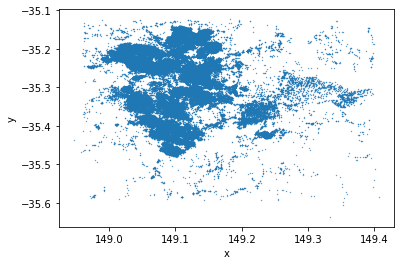

In [51]:
urbanaccess_net.osm_nodes.plot(kind='scatter', x='x', y='y', s=0.1)

In [52]:
ua.gtfs.headways.headways(gtfsfeeds_df=loaded_feeds,
                          headway_timerange=['07:00:00','10:00:00'])

Stop times from 07:00:00 to 10:00:00 successfully selected 83,877 records out of 430,092 total records (19.50 percent of total). Took 0.06 seconds
Starting route stop headway calculation for 7,271 route stops...
Route stop headway calculation complete. Took 21.47 seconds
headway calculation complete. Took 22.54 seconds


In [53]:
ua.network.integrate_network(urbanaccess_network=urbanaccess_net,
                             headways=True,
                             urbanaccess_gtfsfeeds_df=loaded_feeds,
                             headway_statistic='mean')

Loaded UrbanAccess network components comprised of:
     Transit: 2,433 nodes and 80,880 edges;
     OSM: 126,253 nodes and 380,452 edges
routes successfully joined to transit nodes. Took 0.16 seconds
Connector edges between the OSM and transit network nodes successfully completed. Took 4.19 seconds
mean route stop headway will be used for pedestrian to transit edge impedance.
Headway impedance calculation completed. Took 0.07 seconds
Edge and node tables formatted for Pandana with integer node ids: id_int, to_int, and from_int. Took 6.22 seconds
Network edge and node network integration completed successfully resulting in a total of 133,524 nodes and 552,480 edges:
     Transit: 7,271 nodes 80,880 edges;
     OSM: 126,253 nodes 380,452 edges; and
     OSM/Transit connector: 91,148 edges.


Figure created. Took 55.00 seconds


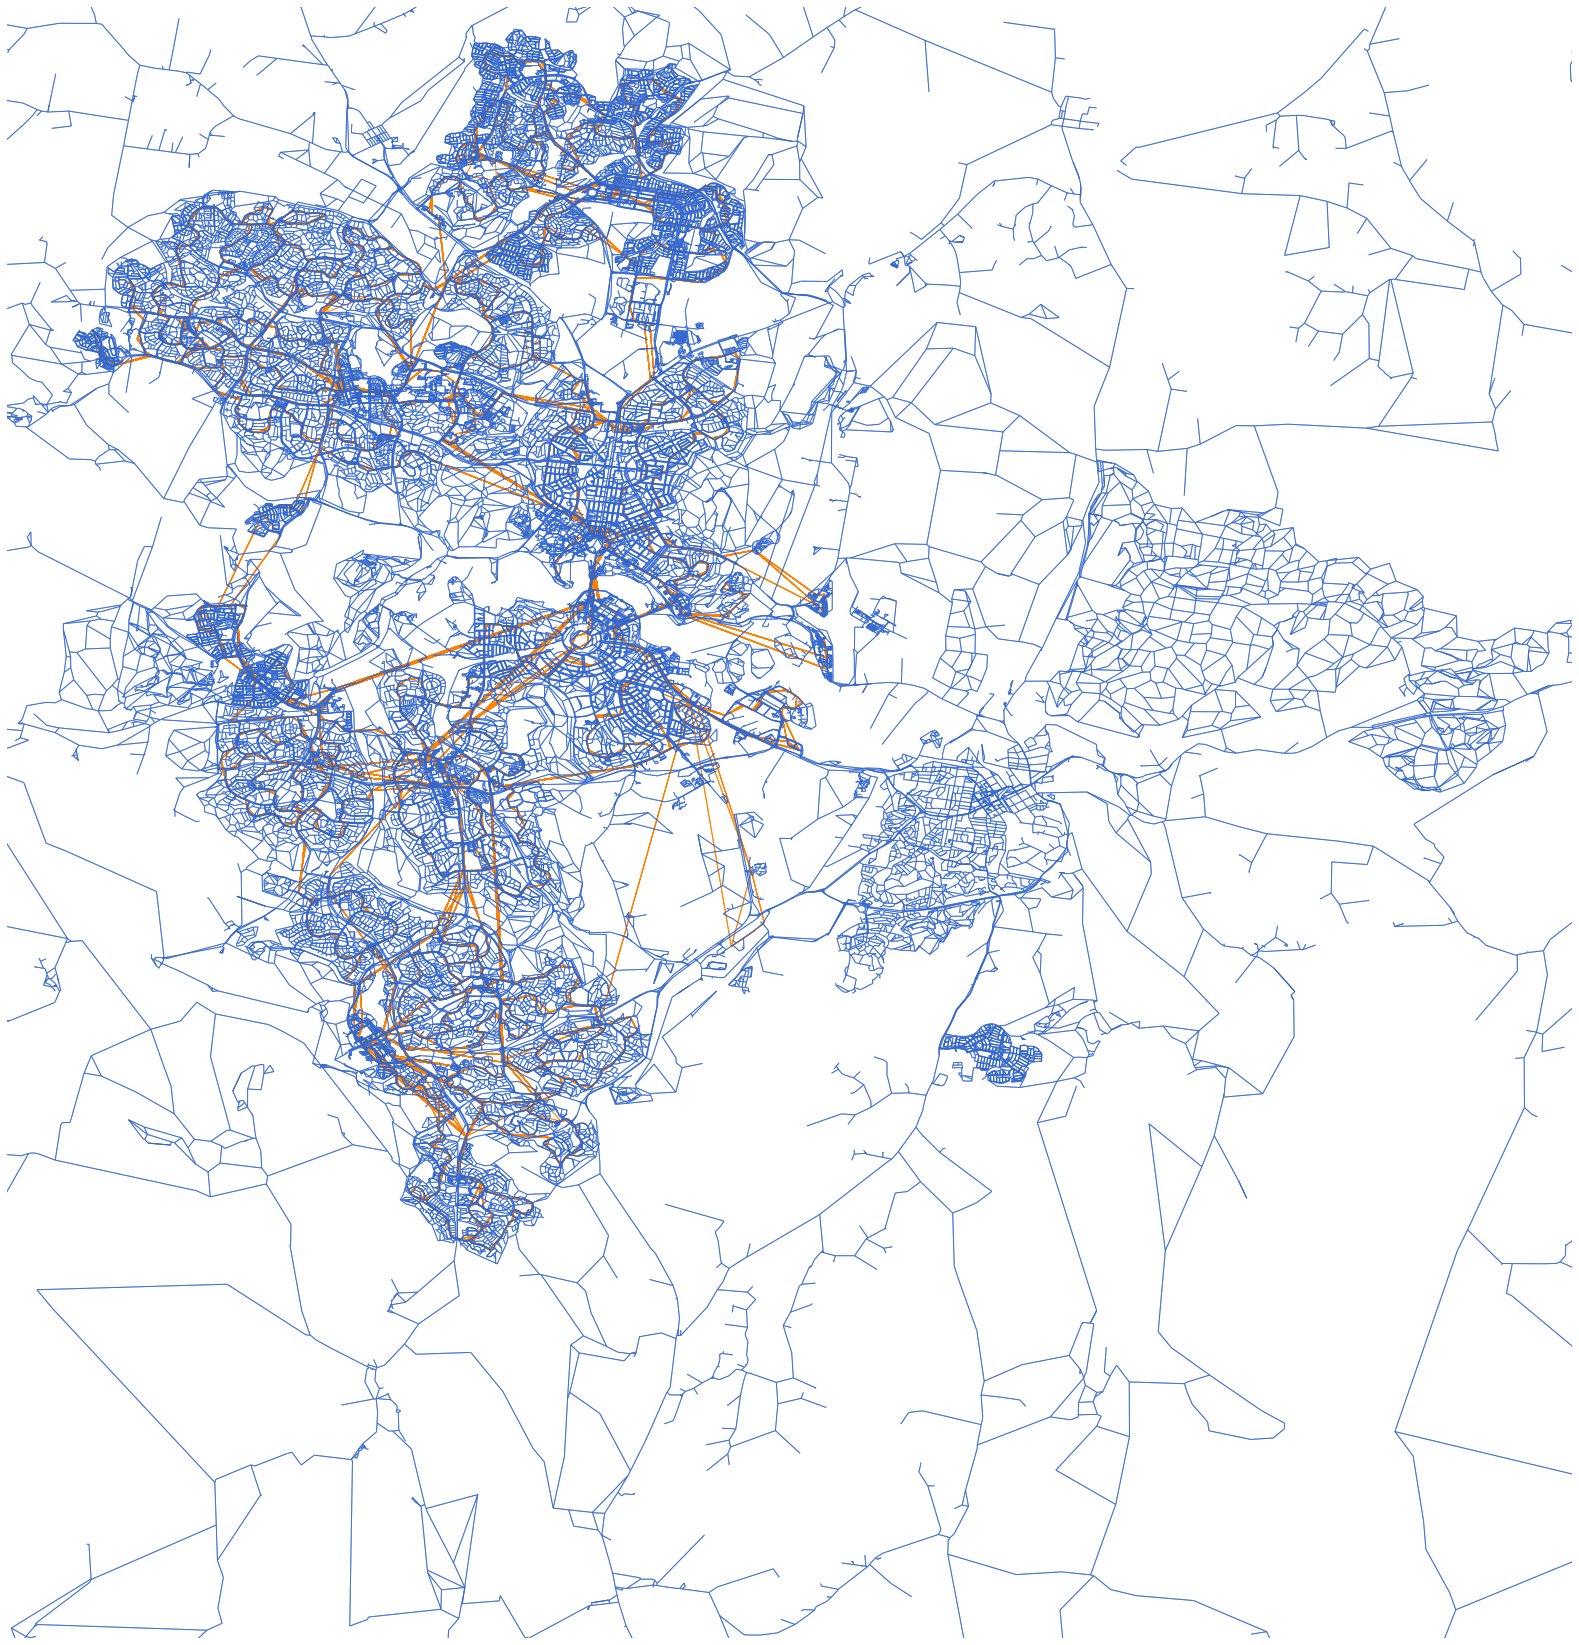

(<Figure size 2019.69x2160 with 1 Axes>, <AxesSubplot:>)

In [54]:
edgecolor = ua.plot.col_colors(df=urbanaccess_net.net_edges, col='weight', cmap='gist_heat_r', num_bins=5)
colours = {'transit':(1, 0.5, 0, 1.00), 
           'walk':(0.2, 0.4, 0.8, 1.00), 
           'transit to osm':(1, 0.4, 0.8, 1.00), 'osm to transit':(0, 0.8, 0, 1.00)}
#orange, blue, pink, green
edgecolour = [colours[x] for x in urbanaccess_net.net_edges['net_type']]
ua.plot.plot_net(nodes=urbanaccess_net.net_nodes,
                 edges=urbanaccess_net.net_edges[(urbanaccess_net.net_edges['net_type']=='transit')|(urbanaccess_net.net_edges['net_type']=='walk')],
                 bbox=bbox_points,
                 #(149.2, -35.3, 149.3, -35.2),
                 fig_height=30, margin=0.02,
                 edge_color=edgecolour, edge_linewidth=1, edge_alpha=0.7,
                 node_color='black', node_size=0, node_alpha=1, node_edgecolor='none', node_zorder=3, nodes_only=False)

In [58]:
ua.network.save_network(urbanaccess_network=urbanaccess_net,
                        filename="Canberra_integrated_net.h5",
                        dir = (folder + "Canberra Data\\"),
                        overwrite_key = True)

New Canberra_integrated_net.h5 hdf5 store created in dir: C:\Users\z3258367\OneDrive - UNSW\#PhD\Walkability\Other Cities\Colouring data & results\Canberra Data\
edges saved in C:\Users\z3258367\OneDrive - UNSW\#PhD\Walkability\Other Cities\Colouring data & results\Canberra Data\/Canberra_integrated_net.h5 hdf5 store.
Using existing C:\Users\z3258367\OneDrive - UNSW\#PhD\Walkability\Other Cities\Colouring data & results\Canberra Data\/Canberra_integrated_net.h5 hdf5 store.
nodes saved in C:\Users\z3258367\OneDrive - UNSW\#PhD\Walkability\Other Cities\Colouring data & results\Canberra Data\/Canberra_integrated_net.h5 hdf5 store.


In [ ]:
urbanaccess_net = ua.network.load_network(dir='data', filename='Canberra_integrated_net.h5')

In [59]:
transit_ped_net = pdna.Network(urbanaccess_net.net_nodes["x"],
                               urbanaccess_net.net_nodes["y"],
                               urbanaccess_net.net_edges["from_int"],
                               urbanaccess_net.net_edges["to_int"],
                               urbanaccess_net.net_edges[["weight"]], 
                               twoway=False)

In [60]:
# earlier results were with gamma 0.025, but have now changed to 0.04.
wgs_pois = pois.to_crs("EPSG:4326")
transit_max_time = 60
# need to change the distance/time decay
transit_gammas = poi_gammas.copy()
transit_gammas = transit_gammas.replace(to_replace=0.001, value=0.04)
transit_gammas

category
employment    0.04
education     0.04
shopping      0.04
errands       0.04
recreation    0.04
Name: distance_constant, dtype: float64

In [103]:
category = 'education'
num_pois = 50
relevant_pois = gpd.GeoDataFrame()
for key in poi_dictionary[category]:
                relevant_pois = pd.concat([relevant_pois, wgs_pois.loc[(wgs_pois[key].isin(poi_dictionary[category][key]))]])
relevant_pois = relevant_pois.reset_index()
x, y = (relevant_pois['geometry'].x, relevant_pois['geometry'].y)
transit_ped_net.set_pois(category, transit_max_time, 50, x, y)
access = transit_ped_net.nearest_pois(
                    distance=transit_max_time, category=category, num_pois=50, include_poi_ids = True)

In [122]:
discounted = access.iloc[:,0:50].applymap(access_weight,distance=transit_max_time,beta=transit_gammas[category]).sum(axis=1)

In [123]:
discounted.loc[89847]

17.24029295576323

In [134]:
dim_opp_weight = [(-np.exp(-poi_lambdas[category]*x)) + np.exp(-poi_lambdas[category]*(x-1)) for x in range(1,num_pois+1)]

In [145]:
(access.iloc[:,0:50].applymap(access_weight,distance=transit_max_time,beta=transit_gammas[category])*dim_opp_weight).sum(axis=1).loc[89847]

0.6053633848146772

In [ ]:
access.loc[89847].iloc[0:50]

In [258]:
relevant_pois.loc[129][5:10]

shop                                NaN
website                             NaN
amenity                       childcare
addr:housenumber                     37
addr:street         Brindabella Circuit
Name: 129, dtype: object

In [164]:
results = there_index(transit_ped_net, wgs_pois, poi_dictionary, poi_weights, transit_gammas,
                            poi_nums, poi_lambdas, poi_variables, distance=transit_max_time)

Finished category: employment
Maximum score: 47.98743458172932 out of 31.9
Finished category: education
Maximum score: 12.266564491172074 out of 14.3
Finished category: shopping
Maximum score: 21.452136590933836 out of 21.6
Finished category: errands
Maximum score: 8.861007492770353 out of 8.9
Finished category: recreation
Maximum score: 23.2863248402852 out of 23.3


In [369]:
results = there_index(transit_ped_net, wgs_pois, poi_dictionary, poi_weights, transit_gammas,
                            poi_nums, poi_lambdas, poi_variables, distance=transit_max_time)

Finished category: employment
Maximum score: 18.6816377303455 out of 31.9
Finished category: education
Maximum score: 12.266564491172074 out of 14.3
Finished category: shopping
Maximum score: 21.452136590933836 out of 21.6
Finished category: errands
Maximum score: 8.861007492770353 out of 8.9
Finished category: recreation
Maximum score: 23.2863248402852 out of 23.3


In [62]:
# old results
# max(results.THERE_Index), np.mean(results.THERE_Index)

(92.69447992748603, 71.57618069043205)

In [165]:
#max(results.THERE_Index), np.mean(results.THERE_Index)

(109.5386225160722, 55.977051147627826)

In [370]:
max(results.THERE_Index), np.mean(results.THERE_Index)

(80.58231525355954, 48.059995910473674)

In [166]:
results[(results.x > 149.125) & (results.x < 149.126) & (results.y < -35.275) & (results.y > -35.285)]
#149.092117,-35.428343

,x,y,Jobs,employment_31.9,employment1,employment2,employment3,employment4,employment5,education_14.3,...,errands3,errands4,errands5,recreation_23.3,recreation1,recreation2,recreation3,recreation4,recreation5,THERE_Index
id_int,,,,,,,,,,,,,,,,,,,,,
91,149.125783,-35.276452,1.461810,46.631736,2.982,3.357,3.436,3.520,3.809,10.347871,...,2.717,3.055,3.315,22.045026,0.844,1.286,1.412,1.412,1.632,106.132562
170,149.125561,-35.279102,1.371889,43.763246,1.939,2.831,2.855,2.862,2.979,9.931841,...,2.269,2.610,2.616,21.865468,0.810,1.250,1.289,1.733,2.348,102.585198
180,149.125561,-35.279102,1.316050,41.982002,1.939,2.831,2.855,2.862,2.979,9.902802,...,2.269,2.610,2.616,21.865468,0.810,1.250,1.289,1.733,2.348,100.486487
200,149.125561,-35.279102,1.397667,44.585587,1.939,2.831,2.855,2.862,2.979,10.050976,...,2.235,2.235,2.269,21.914670,0.810,1.250,1.289,1.733,2.235,103.894669
434,149.125783,-35.276452,1.420387,45.310361,2.982,3.357,3.436,3.453,3.533,10.132111,...,3.121,3.278,3.315,22.785150,0.000,0.000,0.000,0.844,1.286,105.551371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122530,149.125251,-35.275233,1.278747,40.792021,2.436,2.786,2.977,3.996,5.683,10.198369,...,4.044,4.044,5.756,20.732748,0.401,3.452,3.545,3.908,3.987,95.690487
131382,149.125933,-35.281118,1.172332,37.397388,2.151,2.835,2.907,3.314,3.401,9.223030,...,2.500,3.502,4.036,21.428039,1.507,1.656,1.671,2.112,2.474,92.669832
132231,149.125330,-35.281406,1.143685,36.483542,1.077,1.518,1.662,2.187,3.897,9.298065,...,3.197,4.361,4.526,21.727068,0.723,0.824,1.798,1.852,2.249,91.651533


In [343]:
np.max(job_sum)

209745

In [366]:
dim_const = 0.00001653
max_attractiveness = 209745
dim = [(1-np.exp(-dim_const*(x+1))) - (1-np.exp(-dim_const*(x))) for x in range(max_attractiveness + 1)]

In [367]:
dim

[1.6529863380299048e-05,
 1.652959014397659e-05,
 1.6529316911984004e-05,
 1.6529043684765377e-05,
 1.6528770461765596e-05,
 1.6528497243650797e-05,
 1.6528224029754846e-05,
 1.652795082041081e-05,
 1.6527677615729708e-05,
 1.6527404415378477e-05,
 1.6527131219690183e-05,
 1.6526858028553804e-05,
 1.6526584841747294e-05,
 1.652631165960372e-05,
 1.652603848190104e-05,
 1.6525765308750273e-05,
 1.652549214015142e-05,
 1.652521897599346e-05,
 1.6524945816387415e-05,
 1.652467266122226e-05,
 1.6524399510720045e-05,
 1.652412636465872e-05,
 1.6523853223038287e-05,
 1.652358008608079e-05,
 1.6523306953453165e-05,
 1.6523033825599498e-05,
 1.6522760701964678e-05,
 1.6522487583103818e-05,
 1.6522214468572827e-05,
 1.652194135859375e-05,
 1.6521668253166588e-05,
 1.652139515229134e-05,
 1.6521122055856985e-05,
 1.6520848964085566e-05,
 1.6520575876532995e-05,
 1.6520302793754382e-05,
 1.6520029715416662e-05,
 1.6519756641630856e-05,
 1.651948357217492e-05,
 1.6519210507492943e-05,
 1.651893744

In [200]:
category = 'employment'
distance = 60
num_pois = 1200
dist_const = 0.04

relevant_pois = gpd.GeoDataFrame()
for key in poi_dictionary[category]:
    if key in wgs_pois:
        relevant_pois = pd.concat([relevant_pois, wgs_pois.loc[(wgs_pois[key].isin(poi_dictionary[category][key]))]])
                    
relevant_pois = relevant_pois.set_index(poi_variables[category])
                
x, y = (relevant_pois['geometry'].x, relevant_pois['geometry'].y)

transit_ped_net.set_pois(category, distance, num_pois, x, y)

access = transit_ped_net.nearest_pois(
                    distance=distance, category=category, num_pois=num_pois, include_poi_ids=True)

impedance = (access.iloc[:,0:num_pois].applymap(access_weight, distance=distance,beta=dist_const))
jobs = access.iloc[:,num_pois:2*num_pois].values

In [299]:
dist_const = 0.04
impedance = (access.iloc[:,0:num_pois].applymap(access_weight, distance=distance,beta=dist_const))

In [233]:
job_sum = jobs.cumsum(axis=1)

In [234]:
job_sum = np.nan_to_num(job_sum, nan=0.0).astype(np.int64)

In [304]:
result_emp = (np.array(dim)[job_sum]*np.nan_to_num(jobs, nan=0.0)*impedance).sum(axis=1)

In [295]:
np.nan_to_num(jobs, nan=0.0).astype(np.int64)

array([[3917, 6568,  356, ...,    0,    0,    0],
       [3917, 6568,  356, ...,    0,    0,    0],
       [3917, 6568,  701, ...,    0,    0,    0],
       ...,
       [ 126,   32,  103, ...,    0,    0,    0],
       [ 126,  103,  121, ...,    0,    0,    0],
       [ 130,   32,   62, ...,    0,    0,    0]], dtype=int64)

In [354]:
dim[209744]

5.181845277313357e-07

In [345]:
np.array(dim)[job_sum]

IndexError: index 209745 is out of bounds for axis 0 with size 209744

In [305]:
result_emp

id_int
1         0.350227
2         0.394513
3         0.410047
4         0.496683
5         0.515834
            ...   
133520    0.211156
133521    0.211838
133522    0.256903
133523    0.271186
133524    0.246137
Length: 133524, dtype: float64

In [306]:
np.mean(result_emp)*31.9

6.7085254114899975

In [290]:
np.mean(results['employment_31.9'])

14.630851739757773

In [202]:
meshblocks_pt = meshblocks_d.sjoin_nearest(small_pt_results.to_crs(proj_crs), how='left', rsuffix = 'transit')

NameError: name 'meshblocks_d' is not defined

In [314]:
meshblocks_pt = meshblocks.sjoin_nearest(small_pt_results_adg.to_crs(proj_crs), how='left', rsuffix = 'transit')

In [ ]:
meshblocks_pt.loc[6389]

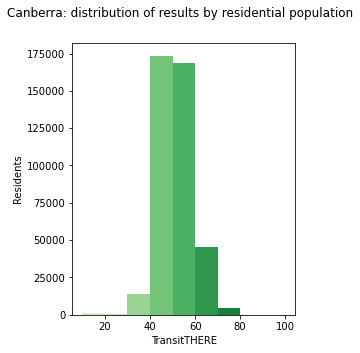

In [321]:
cm = plt.cm.Greens
bins=[10,20,30,40,50,60,70,80,90,100]

fig, ax1 = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(12, 5))
fig.set_figwidth(4)
ax1.set_xlabel('TransitTHERE')
ax1.set_ylabel('Residents')
fig.suptitle('Canberra: distribution of results by residential population')

n, bins, patches = plt.hist(meshblocks_pt['THERE_Index'], weights = meshblocks_pt['Person'], label='TransitTHERE',bins=bins)
for i, p in enumerate(patches):
    plt.setp(p, 'facecolor', cm(i/10 + 0.2)) # notice the i/25
    
plt.show()

In [307]:
result_adj = results.copy()
result_adj['employment_31.9'] = result_emp*31.9

In [311]:
result_adj['THERE_Index'] = result_adj['THERE_Index'] - results['employment_31.9'] + result_adj['employment_31.9']

In [189]:
small_pt_results = gpd.GeoDataFrame(result_rounding(results), geometry = gpd.GeoSeries.from_xy(results.x, results.y, crs=4326))
graph_data = small_pt_results.iloc[::3, :]

In [312]:
small_pt_results_adg = gpd.GeoDataFrame(result_rounding(result_adj), geometry = gpd.GeoSeries.from_xy(result_adj.x, result_adj.y, crs=4326))
graph_data_adg = small_pt_results_adg.iloc[::3, :]

C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\geopandas\plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\geopandas\plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\geopanda

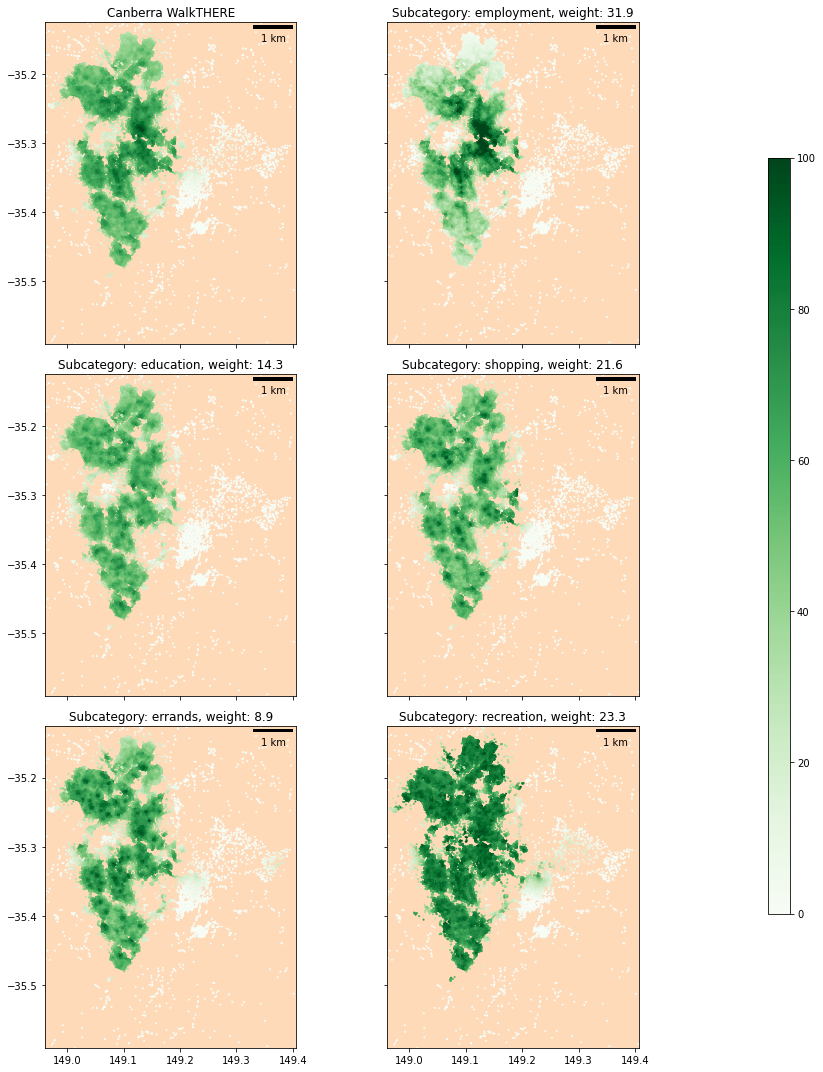

In [193]:
fig, axs = plt.subplots(3,2, sharex=True, sharey=True, 
                       subplot_kw=dict(facecolor="peachpuff",xmargin=0,ymargin=0), 
                       figsize=(12,15))

#for ticker, ax in zip(tickers, axs.ravel()):
for ax in axs.ravel():
    #graph_Sydney.plot(ax = ax, zorder=1, color='peachpuff')
    ax.add_artist(ScaleBar(distance_meters(small_pt_results, 7856), frameon=False))

# put overall index in the first subplot
graph_data.plot(ax = axs[0,0], zorder=2, column= "THERE_Index", 
                     cmap='Greens', markersize=1, vmin=0, vmax=100)
axs[0,0].set_title("Canberra WalkTHERE")

for cat in zip(range(0,len(poi_weights)),poi_weights.items()):
    i = cat[0] + 1 # to skip the first subplot
    ax = axs[i//2,i%2]
    graph_data.plot(ax = ax, zorder=2,
                    column = (cat[1][0] + "_" + str(cat[1][1])),
                    cmap='Greens', markersize=1, vmin=0, vmax = cat[1][1])
    ax.set_title("Subcategory: "+cat[1][0]+", weight: "+str(cat[1][1]))
    
plt.tight_layout()

# Create colorbar scale
sm = plt.cm.ScalarMappable(cmap='Greens', norm=plt.Normalize(vmin=0, vmax=100))
 # empty array for the data range
sm._A = []
# add the colorbar to the figure
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95,0.15,0.025,0.7])
fig.colorbar(sm, cax=cbar_ax)

C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\geopandas\plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\geopandas\plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\geopanda

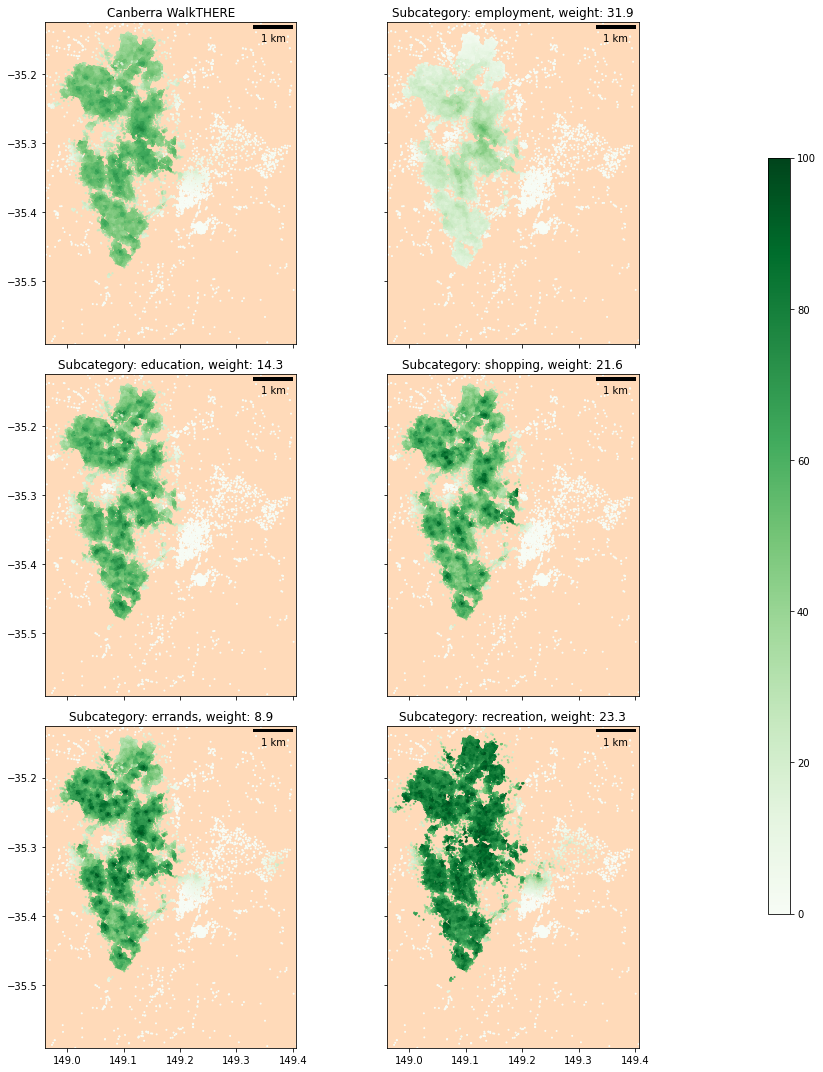

In [313]:
fig, axs = plt.subplots(3,2, sharex=True, sharey=True, 
                       subplot_kw=dict(facecolor="peachpuff",xmargin=0,ymargin=0), 
                       figsize=(12,15))

#for ticker, ax in zip(tickers, axs.ravel()):
for ax in axs.ravel():
    #graph_Sydney.plot(ax = ax, zorder=1, color='peachpuff')
    ax.add_artist(ScaleBar(distance_meters(small_pt_results, 7856), frameon=False))

# put overall index in the first subplot
graph_data_adg.plot(ax = axs[0,0], zorder=2, column= "THERE_Index", 
                     cmap='Greens', markersize=1, vmin=0, vmax=100)
axs[0,0].set_title("Canberra WalkTHERE")

for cat in zip(range(0,len(poi_weights)),poi_weights.items()):
    i = cat[0] + 1 # to skip the first subplot
    ax = axs[i//2,i%2]
    graph_data_adg.plot(ax = ax, zorder=2,
                    column = (cat[1][0] + "_" + str(cat[1][1])),
                    cmap='Greens', markersize=1, vmin=0, vmax = cat[1][1])
    ax.set_title("Subcategory: "+cat[1][0]+", weight: "+str(cat[1][1]))
    
plt.tight_layout()

# Create colorbar scale
sm = plt.cm.ScalarMappable(cmap='Greens', norm=plt.Normalize(vmin=0, vmax=100))
 # empty array for the data range
sm._A = []
# add the colorbar to the figure
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95,0.15,0.025,0.7])
fig.colorbar(sm, cax=cbar_ax)

In [290]:
meshblocks_pt.iloc[:,33:39], meshblocks_pt.iloc[:,139:145], meshblocks_pt.iloc[:,69:75], meshblocks_pt.iloc[:,104:110]

(      education1_left  education2_left  education3_left  education4_left  \
 0                85.0           2087.0           2198.0           2400.0   
 1              1980.0           2400.0           2400.0           2400.0   
 2              2017.0           2400.0           2400.0           2400.0   
 3              1929.0           2400.0           2400.0           2400.0   
 4              2030.0           2080.0           2400.0           2400.0   
 ...               ...              ...              ...              ...   
 6366           1291.0           2400.0           2400.0           2400.0   
 6367           1496.0           2400.0           2400.0           2400.0   
 6368           1685.0           2400.0           2400.0           2400.0   
 6369           1596.0           2400.0           2400.0           2400.0   
 6370           1907.0           2400.0           2400.0           2400.0   
 
       education5_left  education_14.3_left  
 0              2400.0      

In [18]:
meshblocks_pt.filter(like='Jobs', axis=1)

,Jobs_left,Jobs_cycle,Jobs_drive,Jobs
0,13.0,8078.0,14615.0,7268.0
1,107.0,9009.0,16885.0,17203.0
2,104.0,9082.0,16995.0,17384.0
3,114.0,9324.0,16995.0,18095.0
4,154.0,8836.0,17262.0,18750.0
...,...,...,...,...
6569,89.0,4459.0,9296.0,9833.0
6570,72.0,4148.0,8998.0,9228.0
6571,60.0,3993.0,8885.0,7958.0
6572,65.0,4024.0,8884.0,9407.0


In [24]:
sum(employment_centrs.Jobs)

215451.9999999999

In [19]:
meshblocks_pt.filter(like='employment_', axis=1)

,employment_31.9_left,employment_31.9_cycle,employment_31.9_drive,employment_31.9
0,0.007,3.987,6.846,3.611
1,0.057,4.414,7.769,7.896
2,0.055,4.447,7.813,7.967
3,0.060,4.556,7.813,8.247
4,0.081,4.335,7.919,8.502
...,...,...,...,...
6569,0.047,2.267,4.544,4.786
6570,0.038,2.114,4.409,4.513
6571,0.031,2.038,4.358,3.932
6572,0.034,2.053,4.357,4.594


In [15]:
np.mean(meshblocks_pt['THERE_Index_cycle'] - meshblocks_pt['THERE_Index_drive'])

-8.517317158503195

### Re import for graphs

In [258]:
meshblocks_w = gpd.read_file((folder + "Canberra Data\\Canberra MB results 4m 150622.gpkg"))

In [265]:
np.mean(meshblocks_w['THERE_Index'])

61.539482050501974

C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\geopandas\plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\geopandas\plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\geopanda

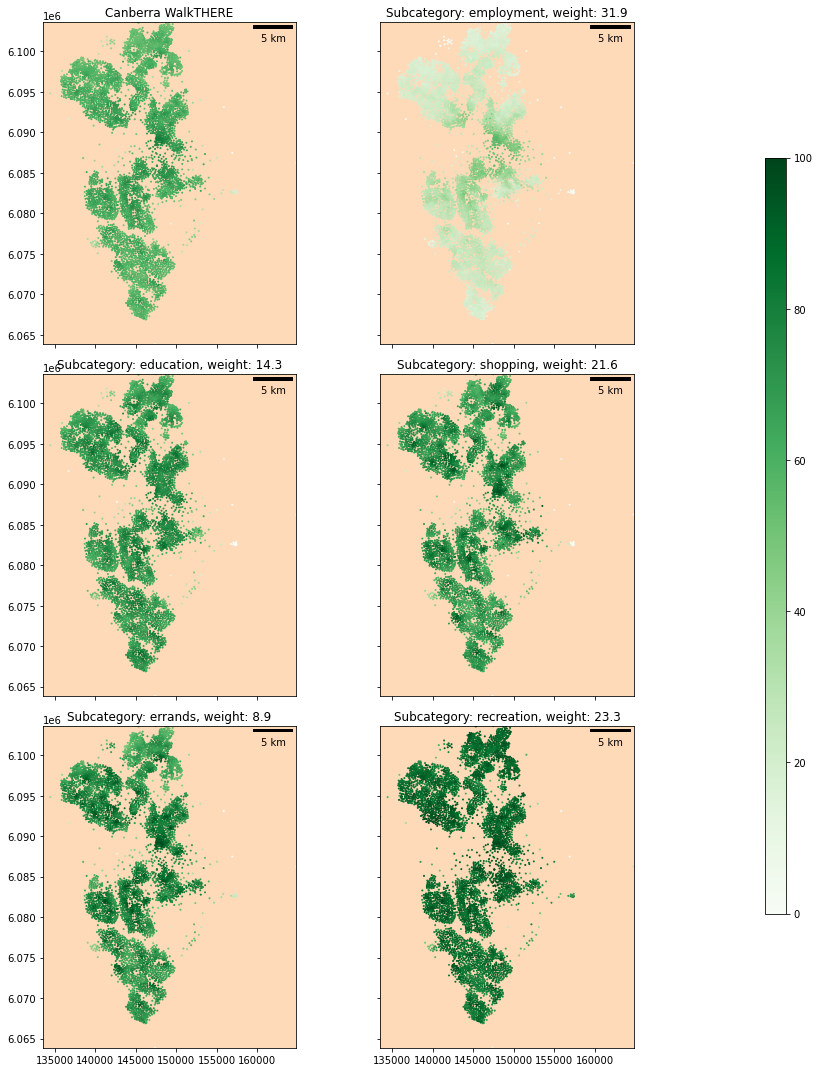

In [277]:
fig, axs = plt.subplots(3,2, sharex=True, sharey=True, 
                       subplot_kw=dict(facecolor="peachpuff",xmargin=0,ymargin=0), 
                       figsize=(12,15))

#for ticker, ax in zip(tickers, axs.ravel()):
for ax in axs.ravel():
    #graph_Sydney.plot(ax = ax, zorder=1, color='peachpuff')
    ax.add_artist(ScaleBar(1, frameon=False))

# put overall index in the first subplot
meshblocks_w.plot(ax = axs[0,0], zorder=2, column= "THERE_Index", 
                     cmap='Greens', markersize=1, vmin=0, vmax=100)
axs[0,0].set_title("Canberra WalkTHERE")

for cat in zip(range(0,len(poi_weights)),poi_weights.items()):
    i = cat[0] + 1 # to skip the first subplot
    ax = axs[i//2,i%2]
    meshblocks_w.plot(ax = ax, zorder=2,
                    column = (cat[1][0] + "_" + str(cat[1][1])),
                    cmap='Greens', markersize=1, vmin=0, vmax = cat[1][1])
    ax.set_title("Subcategory: "+cat[1][0]+", weight: "+str(cat[1][1]))
    
plt.tight_layout()

# Create colorbar scale
sm = plt.cm.ScalarMappable(cmap='Greens', norm=plt.Normalize(vmin=0, vmax=100))
 # empty array for the data range
sm._A = []
# add the colorbar to the figure
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95,0.15,0.025,0.7])
fig.colorbar(sm, cax=cbar_ax)

Text(0.5, 0.98, 'Canberra: distribution of results by residential population')

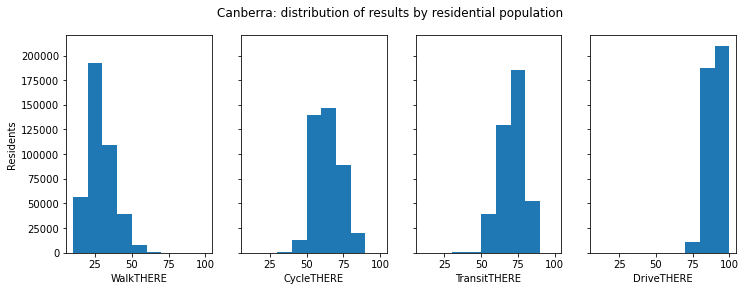

In [175]:
fig, [ax1, ax2, ax3, ax4] = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(12, 4))
#f.set_figwidth(4)
bins=[10,20,30,40,50,60,70,80,90,100]
ax1.hist(meshblocks_w['THERE_Index_walking'], weights = meshblocks_w['Persons'], label='WalkTHERE',bins=bins)
ax1.set_xlabel('WalkTHERE')
ax1.set_ylabel('Residents')
ax2.hist(meshblocks_w['THERE_Index_cycle'], weights = meshblocks_w['Persons'],bins=bins)
ax2.set_xlabel('CycleTHERE')
ax3.hist(meshblocks_w['THERE_Index_left'], weights = meshblocks_w['Persons'],bins=bins)
ax3.set_xlabel('TransitTHERE')
ax4.hist(meshblocks_w['THERE_Index_drive'], weights = meshblocks_w['Persons'],bins=bins)
ax4.set_xlabel('DriveTHERE')
fig.suptitle('Canberra: distribution of results by residential population')

Text(0.5, 0.98, 'Canberra: distribution of results by residential population')

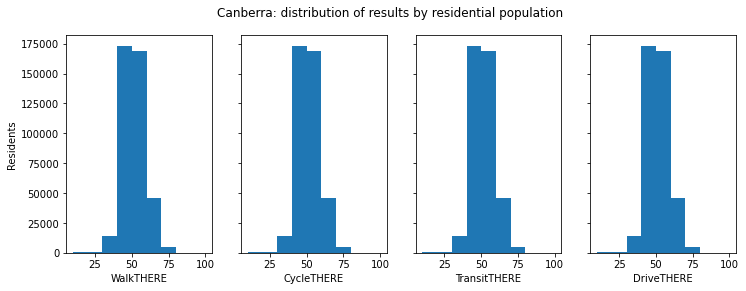

In [322]:
fig, [ax1, ax2, ax3, ax4] = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(12, 4))
#f.set_figwidth(4)
bins=[10,20,30,40,50,60,70,80,90,100]
ax1.hist(meshblocks_pt['THERE_Index'], weights = meshblocks_pt['Persons'], label='WalkTHERE',bins=bins)
ax1.set_xlabel('WalkTHERE')
ax1.set_ylabel('Residents')
ax2.hist(meshblocks_pt['THERE_Index'], weights = meshblocks_pt['Persons'],bins=bins)
ax2.set_xlabel('CycleTHERE')
ax3.hist(meshblocks_pt['THERE_Index'], weights = meshblocks_pt['Persons'],bins=bins)
ax3.set_xlabel('TransitTHERE')
ax4.hist(meshblocks_pt['THERE_Index'], weights = meshblocks_pt['Persons'],bins=bins)
ax4.set_xlabel('DriveTHERE')
fig.suptitle('Canberra: distribution of results by residential population')